In [1]:
import pandas as pd
import numpy as np

#Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches

# Explore selected datasets

In this project, we use data from [BIXI](https://bixi.com/fr/donnees-ouvertes), a bike sharing company in Montréal (Canada), and the [daily temperature average](https://climate.weather.gc.ca/historical_data/search_historic_data_e.html) to better understand how temperature impact biking usage in Montréal.

For data exploration, we chose to only  use data from 2020:
- A log of all the BIXI events (N=3 264 741)
- All the BIXI station in Montréal (N=641)
- Daily log of temperature in Montréal (N=366)

In this Notebook, we **check the formating of each raw data file**: 1) identify the variables in each file, 2) select which variables can be use to reach our analytics goal and 3) understand the formating of each file and its variables. Then, we can **check the quality of the data** prior starting the project, we need to: 1) check if there is missing values, 2) where missing values are and 3) what to do with them.  

## All trips completed with a BIXI

This dataset append a new row each time a new trip starts. Data in this table include:
- **start_date**: when the person took the BIXI from the station
- **start_station_code**: which station the BIXI was taking from
- **end_date**: when the person return the BIXI to a station
- **end_station_code**: which station the person return the BIXI to
- **duration_sec**: how long was the trip in second
- **is_member**: if the person have a BIXI membership  
    - 0 = is not a BIXI's member
    - 1 = is a BIXI's member

In [2]:
# Load CSV dataset for 2020
trips = pd.read_csv('./raw_data/raw_bixi_trips/bixi_trips_2020.csv')

# Ensure date-type for data exploration
trips['start_date'] = pd.to_datetime(trips['start_date'])
trips['end_date'] = pd.to_datetime(trips['end_date'])

# Check how the table is formated and how much row it contains
print(f"This dataset contains {len(trips)} trips")
trips.head()

This dataset contains 3264741 trips


,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2020-04-15 06:00:04,6212,2020-04-15 06:20:54,6250,1250,1
1,2020-04-15 06:05:41,6369,2020-04-15 06:32:47,6072,1626,1
2,2020-04-15 06:07:27,6207,2020-04-15 06:19:32,7038,724,1
3,2020-04-15 06:09:16,6202,2020-04-15 06:18:49,6212,572,1
4,2020-04-15 06:09:38,6159,2020-04-15 06:24:23,7067,885,1


In [3]:
# Check info about dataset
trips.info()

# Get a description of each column
trips.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264741 entries, 0 to 3264740
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_date          datetime64[ns]
 1   start_station_code  int64         
 2   end_date            datetime64[ns]
 3   end_station_code    int64         
 4   duration_sec        int64         
 5   is_member           int64         
dtypes: datetime64[ns](2), int64(4)
memory usage: 149.4 MB


,start_station_code,end_station_code,duration_sec,is_member
count,3.264741e+06,3.264741e+06,3.264741e+06,3.264741e+06
mean,6.399046e+03,6.399199e+03,9.363313e+02,7.966846e-01
std,4.269501e+02,4.399925e+02,7.234184e+02,4.024652e-01
min,4.000000e+03,4.000000e+03,6.100000e+01,0.000000e+00
25%,6.142000e+03,6.134000e+03,4.210000e+02,1.000000e+00
50%,6.237000e+03,6.240000e+03,7.530000e+02,1.000000e+00
75%,6.708000e+03,6.712000e+03,1.264000e+03,1.000000e+00
max,1.000200e+04,1.000200e+04,7.199000e+03,1.000000e+00


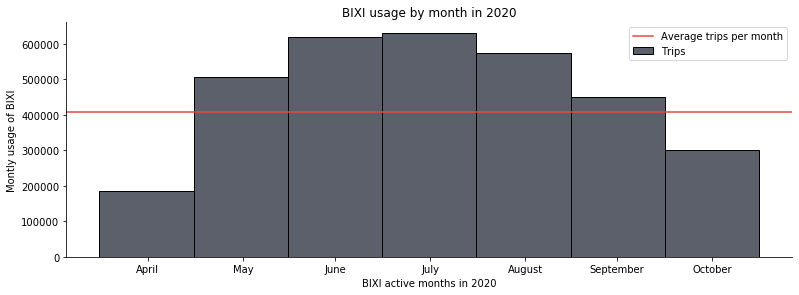

In [4]:
# Observe date distribution by month (April to November)
sns.displot(trips, x="start_date", bins=7, height=4, aspect=2.8, color='#252b39', label='Trips')\
    .set_xticklabels(['April','May','June','July','August','September','October','November'])

plt.xlabel('BIXI active months in 2020')
plt.ylabel('Montly usage of BIXI')
plt.title('BIXI usage by month in 2020')

# Average amount of trips per month
trips_month = trips
trips_month['month'] = pd.DatetimeIndex(trips['start_date']).month
average = trips_month.groupby(['month']).count()['start_date'].mean()

plt.axhline(y=average, color='#eb483c', linestyle='-', label="Average trips per month")
plt.legend(loc="upper right")

Each year, BIXI run from mid-april to the end of november based on snow conditions. It is thus expected to see less trips in April and November. Amount of trips per month seem consistent as there is no month that seems out of the ordinary.  

## All BIXI stations in Montréal

This dataset show all the BIXI stations in Montréal. Data include:
- **code**: unique number for a station
- **name**: Name of the station place (usualy based on the closest streets intersections: street1/street2)
- **latitude**: coordinates of the station
- **longitude**: coordinates of the station

In [5]:
# Load CSV dataset for 2020
stations = pd.read_csv("./raw_data/raw_stations/stations_2020.csv")

# Check how the table is formated and how much row it contains
print(f"This dataset contains {len(stations)} stations")
stations.head()

This dataset contains 641 stations


,code,name,latitude,longitude
0,6001,Métro Champ-de-Mars (Viger / Sanguinet),45.510163,-73.556637
1,6002,Ste-Catherine / Dezery,45.539385,-73.541000
2,6003,Clark / Ontario,45.510824,-73.567172
3,6004,du Champ-de-Mars / Gosford,45.509655,-73.554009
4,6005,Metcalfe / du Square-Dorchester,45.500208,-73.571138


In [6]:
# Check info about dataset
stations.info()

# Get a description of each column
stations.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   code       641 non-null    int64  
 1   name       641 non-null    object 
 2   latitude   641 non-null    float64
 3   longitude  641 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 20.2+ KB


,code,latitude,longitude
count,641.000000,641.000000,641.000000
mean,6534.639626,45.521389,-73.587520
std,543.382467,0.034823,0.037001
min,4000.000000,45.416310,-73.744440
25%,6166.000000,45.501041,-73.607798
50%,6364.000000,45.523530,-73.579187
75%,7015.000000,45.540958,-73.564601
max,10002.000000,45.651406,-73.490113


The is no NULL data in the BIXI station dataset. 

Downtown Montréal is located at latitude=45.508888 and longitude=-73.561668. Descriptive information from this dataset such as min, max, mean and std on the longitude and latitude data seem to be appropriate for Montreal geolocalisation. 

---

In order to confirm that our stations location are in Montréal, we will display the location of the stations on the montreal map. 

In [7]:
# Change individual columns of latitude/longitude to WGS84 latitude-longitude projection
locations=[Point(xy) for xy in zip(stations["longitude"], stations['latitude'])]
geo_location = gpd.GeoDataFrame(stations, geometry=locations)

# Load Montreal map and transform geolocalisation data to WGS84 latitude-longitude projection
montreal_road_map = gpd.read_file('./maps/vmtl_roadmap.geojson').to_crs(epsg=4326)

# Load Montreal Arrondisement
montreal_city_map = gpd.read_file('./maps/vmtl_montreal_borders.zip').to_crs(epsg=4326)

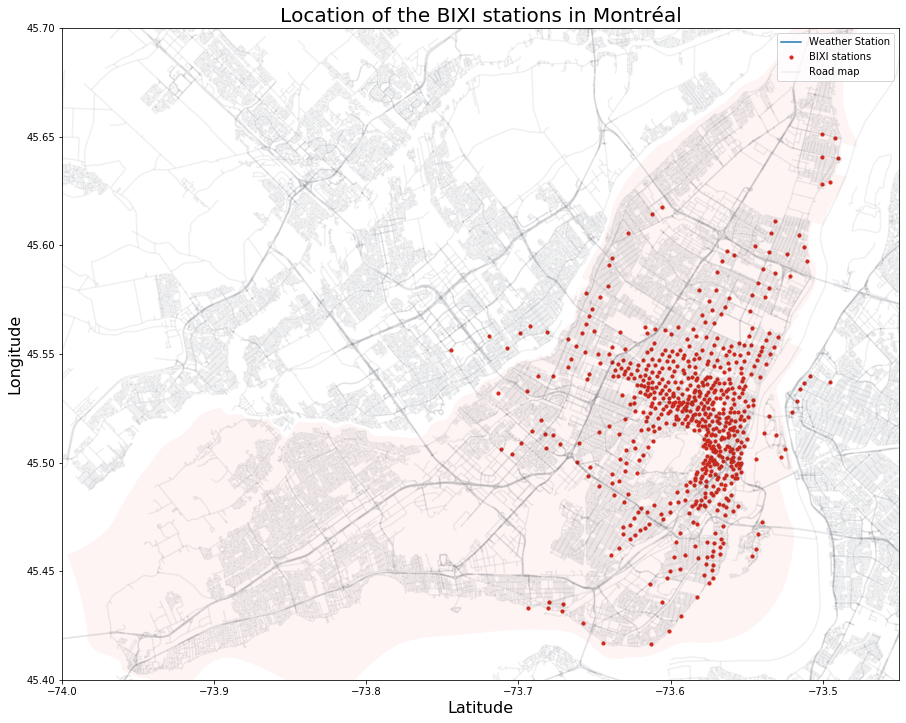

In [8]:
# Create map with Montreal and BIXI stations
fig, ax = plt.subplots(figsize=(15,15))

geo_location.plot(ax=ax,color='#da291c', markersize=10, alpha=1, label='BIXI stations')
montreal_city_map.plot(ax=ax, alpha=0.05, color='#da291c', label='Montreal island boundary') # Won't show in legend
montreal_road_map.plot(ax=ax, alpha=0.07, color='#252b39', label='Road map')
plt.plot([45.47,-73.74], label='Weather Station') 

plt.xlabel('Latitude', size=16)
plt.ylabel('Longitude', size=16)
plt.title('Location of the BIXI stations in Montréal', size=20)

plt.legend()

# À posteriori: Zoom the map to better see BIXI stations // only use after data quality is checked.
plt.xlim([-74.0, -73.45])
plt.ylim([45.4, 45.7])

# Show map
plt.show();

All the coordinates are located in the greater Montreal area. This include some stations in Laval (North of Montréal) and some in Longeuil (South of Montréal). 

## Daily weather in Montréal

Dataset chosen for the weather includes the follonwing variables:

| Variable Name      	| Description               	| Unit    	|
|--------------------	|---------------------------	|---------	|
| day                	| Date                      	| -       	|
| mont               	| Date                      	| -       	|
| year               	| Date                      	| -       	|
| maxtemp            	| Maximum Temperature       	| °C      	|
| mintemp            	| Minimum Temperature       	| °C      	|
| meantemp           	| Mean Temperature          	| °C      	|
| heatdegdays        	| Heating Degree Days       	| °C      	|
| cooldegdays        	| Cooling Degree Days       	| mm      	|
| totalrain          	| Total Rain                	| mm      	|
| totalsnow          	| Total Snow                	| cm      	|
| totalprecipitation 	| Total Precipitation       	| mm      	|
| snowonground       	| Snow on Ground            	| cm      	|
| dirofmaxgust       	| Direction of Maximum Gust 	| 10s Deg 	|
| - speedofmaxgust   	| Speed of Maximum Gust     	| km/h    	|

In [9]:
# Load XML dataset for 2020
weather = pd.read_xml("./raw_data/raw_weather/weather_2020.xml", "./stationdata")
print(f"The full dataset contains {len(weather)} days")

weather = weather.loc[(weather['month']>=4) & (weather['month']<=11)] # Select only april to november for data exploration
print(f"The april-november dataset contains {len(weather)} days")

# Check how the table is formated and how much row it contains
weather.head()

The full dataset contains 366 days
The april-november dataset contains 244 days


,day,month,year,maxtemp,mintemp,meantemp,heatdegdays,cooldegdays,totalrain,totalsnow,totalprecipitation,snowonground,dirofmaxgust,speedofmaxgust
91,1,4,2020,6.4,-0.8,2.8,15.2,0.0,NaN,NaN,0.0,0.0,5.0,36.0
92,2,4,2020,6.5,0.7,3.6,14.4,0.0,NaN,NaN,9.0,0.0,3.0,34.0
93,3,4,2020,9.6,5.3,7.4,10.6,0.0,NaN,NaN,11.0,0.0,4.0,53.0
94,4,4,2020,12.9,2.0,7.4,10.6,0.0,NaN,NaN,0.2,0.0,NaN,NaN
95,5,4,2020,10.2,1.3,5.8,12.2,0.0,NaN,NaN,0.0,0.0,30.0,34.0


In [10]:
# Check info about dataset
weather.info()

# Get a description of each column
weather.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 91 to 334
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   day                 244 non-null    int64  
 1   month               244 non-null    int64  
 2   year                244 non-null    int64  
 3   maxtemp             241 non-null    float64
 4   mintemp             241 non-null    float64
 5   meantemp            241 non-null    float64
 6   heatdegdays         241 non-null    float64
 7   cooldegdays         241 non-null    float64
 8   totalrain           0 non-null      float64
 9   totalsnow           0 non-null      float64
 10  totalprecipitation  240 non-null    float64
 11  snowonground        14 non-null     float64
 12  dirofmaxgust        165 non-null    float64
 13  speedofmaxgust      165 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 28.6 KB


,day,month,year,maxtemp,mintemp,meantemp,heatdegdays,cooldegdays,totalrain,totalsnow,totalprecipitation,snowonground,dirofmaxgust,speedofmaxgust
count,244.000000,244.000000,244.0,241.000000,241.000000,241.000000,241.000000,241.000000,0.0,0.0,240.000000,14.000000,165.000000,165.000000
mean,15.754098,7.500000,2020.0,18.951867,9.057261,14.001660,5.802905,1.804564,NaN,NaN,2.600000,0.357143,21.521212,43.618182
std,8.825059,2.288817,0.0,8.874585,7.956478,8.241359,6.207612,2.890476,NaN,NaN,6.136883,0.841897,9.583133,9.967308
min,1.000000,4.000000,2020.0,-2.400000,-6.100000,-4.300000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,1.000000,31.000000
25%,8.000000,5.750000,2020.0,11.700000,2.000000,7.400000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,16.000000,36.000000
50%,16.000000,7.500000,2020.0,19.700000,8.600000,14.300000,3.700000,0.000000,NaN,NaN,0.000000,0.000000,25.000000,42.000000
75%,23.000000,9.250000,2020.0,26.500000,15.900000,21.500000,10.600000,3.500000,NaN,NaN,1.225000,0.000000,29.000000,48.000000
max,31.000000,11.000000,2020.0,36.100000,23.700000,29.900000,22.300000,11.900000,NaN,NaN,39.700000,3.000000,36.000000,80.000000


In [11]:
weather.loc[weather['meantemp'].isna()]

,day,month,year,maxtemp,mintemp,meantemp,heatdegdays,cooldegdays,totalrain,totalsnow,totalprecipitation,snowonground,dirofmaxgust,speedofmaxgust
240,28,8,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,1,9,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2,9,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Three days in the dataset (april-november) do not contains any data:
- August 28, 2020
- September 1st, 2020
- September 2nd, 2020

Those missing data can be cause by many factors such as equipment failure or extremely bad weather. For our data engineering pipeline, it is important to be aware of these missing data. 

Missing data in the weather should only be problematic if there is a lot of missing data and if they always appear in the same month, it should not pose any problem with the analytic goal of the this project. 

---

While not implemented for this project, we could consider using a different but close station to fill the missing data. 

The current station used: MONTREAL/PIERRE ELLIOTT TRUDEAU INTL
Alternative stations includes:
- MONTREAL INTL A
- MONTREAL MIRABEL INTL A
- MONTREAL/ST-HUBERT A